# comparatorのシミュレーション

このノートブックでは、量子ビット間の大小比較を行うcomparatorについて、テンソルネットワークシミュレーションを試みる。

まずは必要なライブラリをインストールする。

（参考）  
- tensornetworkの公式ドキュメント：  
https://tensornetwork.readthedocs.io/en/latest/index.html

- Qiskitの公式ドキュメント：  
https://qiskit.org/documentation/

In [ ]:
%pip install tensornetwork

In [ ]:
%pip install qiskit

In [ ]:
%pip install pylatexenc

## comparatorとは

二つのビット列A,Bを受け取り、2進数としての大小関係を判定するアルゴリズム

出力は、2量子ビットで、以下の3通りのいずれかとなる。
- Aのほうが大きい (10)
- Bのほうが大きい (01)
- 両者は等しい    (00)

論文は以下。

[David Sena Oliveira, and Rubens Viana Ramos. "Quantum bit string comparator: circuits and applications." Quantum Comput. Comput 7.1 (2007): 17-26.](https://www.researchgate.net/publication/228574906_Quantum_bit_string_comparator_Circuits_and_applications)

## 回路の概要

回路は入力するビット列長を$n$とすると、$5n-1$量子ビットが必要となる。  
各量子ビットについて、大小関係を比較し、その結果を上位に伝播させるような回路となっている。  
最終的に、比較結果を取り出すためには、以下の図の$O_1O_2$の2量子ビットを観測する必要がある。

（図は論文中より引用した回路図に、説明を付け加えたもの）

白丸のTofforiゲートは、入力が00のときに、標的ビットを反転させるもの

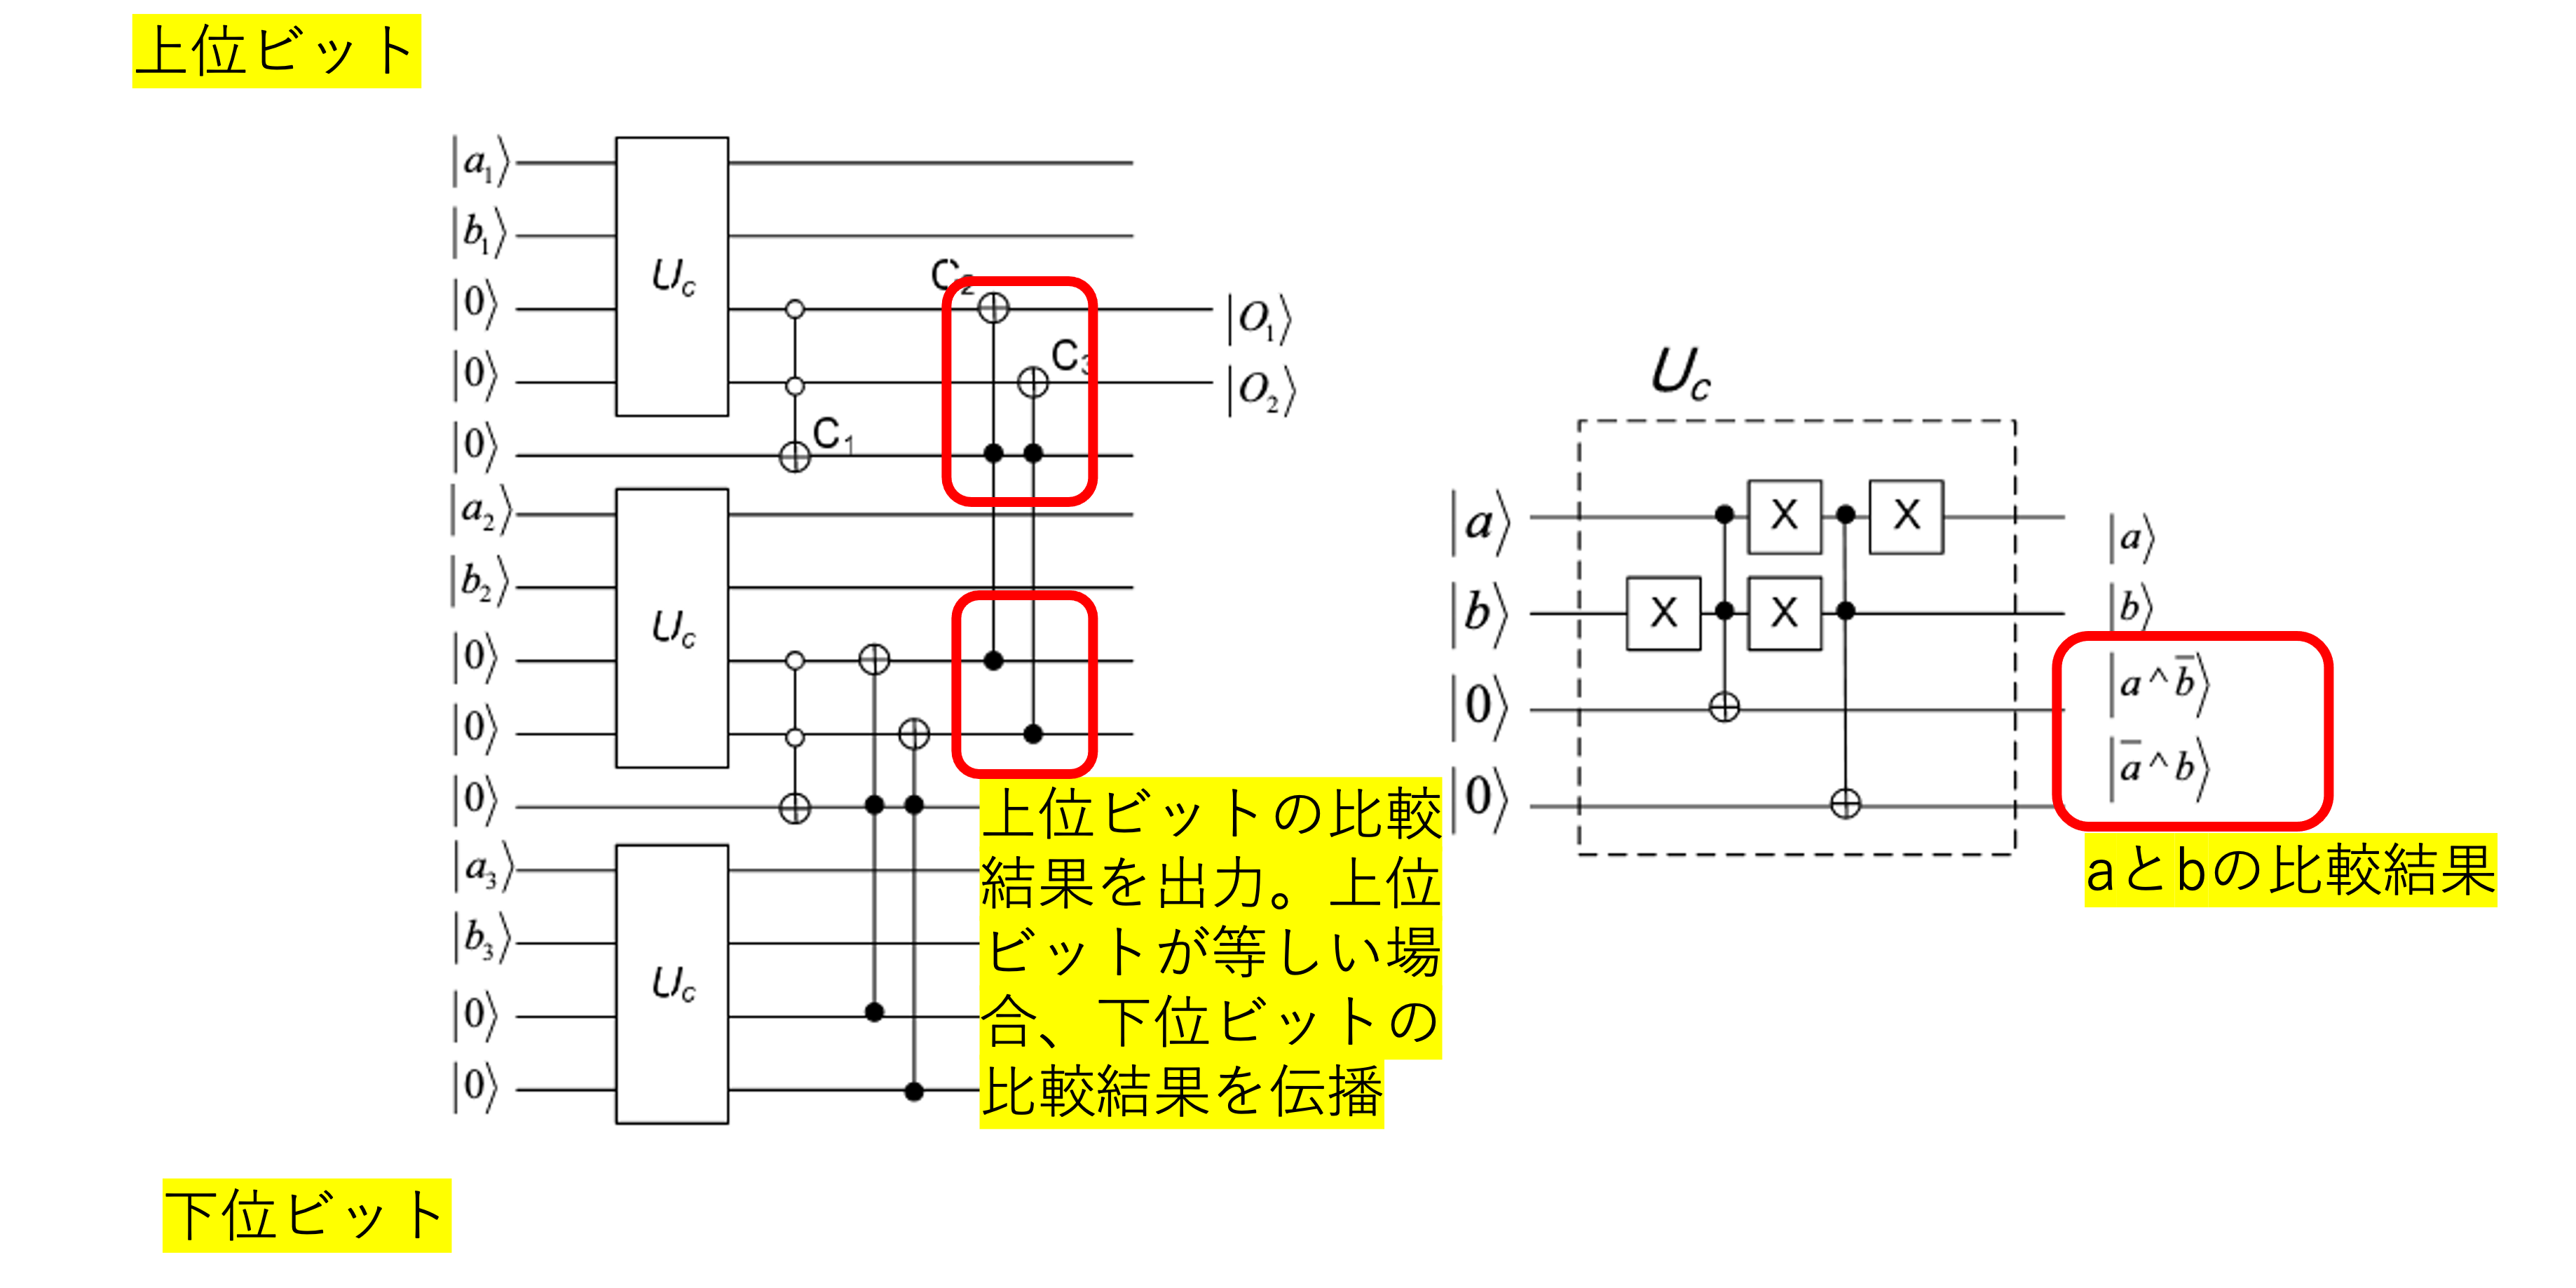

## Qiskitによるシミュレーション

まずは、この回路をQiskit上で実装し、通常のシミュレーション（＝シュレディンガーシミュレーション）を実施してみる。

In [ ]:
import numpy as np
import qiskit
from qiskit import Aer

In [ ]:
# パラメータ設定
bit_length = 3 # 入力するビット列の長さ

# 以下は変更不要
n_qubits = bit_length * 5 - 1
backend_sim = Aer.get_backend('qasm_simulator')

In [ ]:
circ = qiskit.QuantumCircuit(n_qubits, 2)

# input

circ.x(0) # ここではAの最上位ビットだけ反転させる


circ.barrier(range(n_qubits))

# U_c
for i in range(bit_length):
    circ.x(i*5 + 1)
    circ.ccx(i*5, i*5+1, i*5+2)
    circ.x(i*5)
    circ.x(i*5+1)
    circ.ccx(i*5, i*5+1, i*5+3)
    circ.x(i*5)

circ.barrier(range(n_qubits))

for i in range(bit_length - 1):
    circ.x(i*5+2)
    circ.x(i*5+3)
    circ.ccx(i*5 + 2, i*5 + 3,  i*5 + 4)
    circ.x(i*5+2)
    circ.x(i*5+3)

circ.barrier(range(n_qubits))

for i in range(bit_length-1, 0, -1):
    circ.ccx(i*5+2, i*5-1, i*5-3)
    circ.ccx(i*5+3, i*5-1, i*5-2)

circ.measure([2, 3], [0, 1])

In [ ]:
circ.draw('mpl')

In [ ]:
%%time

# シミュレーションの実行、結果の確認
job_sim = backend_sim.run(qiskit.transpile(circ, backend_sim))
result_sim = job_sim.result()
counts = result_sim.get_counts(circ)
print(counts)

Qiskitでは上位ビットほど右側にくる点に注意してください。

## 課題1
上記回路のビット長や、入力ビット列を変化させて、出力の変化を確認してみましょう。  
（重ね合わせ状態なども入力してみてください。）

ビット長を大きくしすぎるとメモリ不足でエラーになるので気をつけてください。

---

## テンソルネットワークシミュレーション

今回は2量子ビットのみを測定すればよいため、特定状態の振幅を測るような手法ではなく、密度行列を用いて、2量子ビットの確率を確認する

同じ回路を反転させて、結合させたようなネットワークを用意し、測定に対応する部分の足だけを結合させずに残しておく

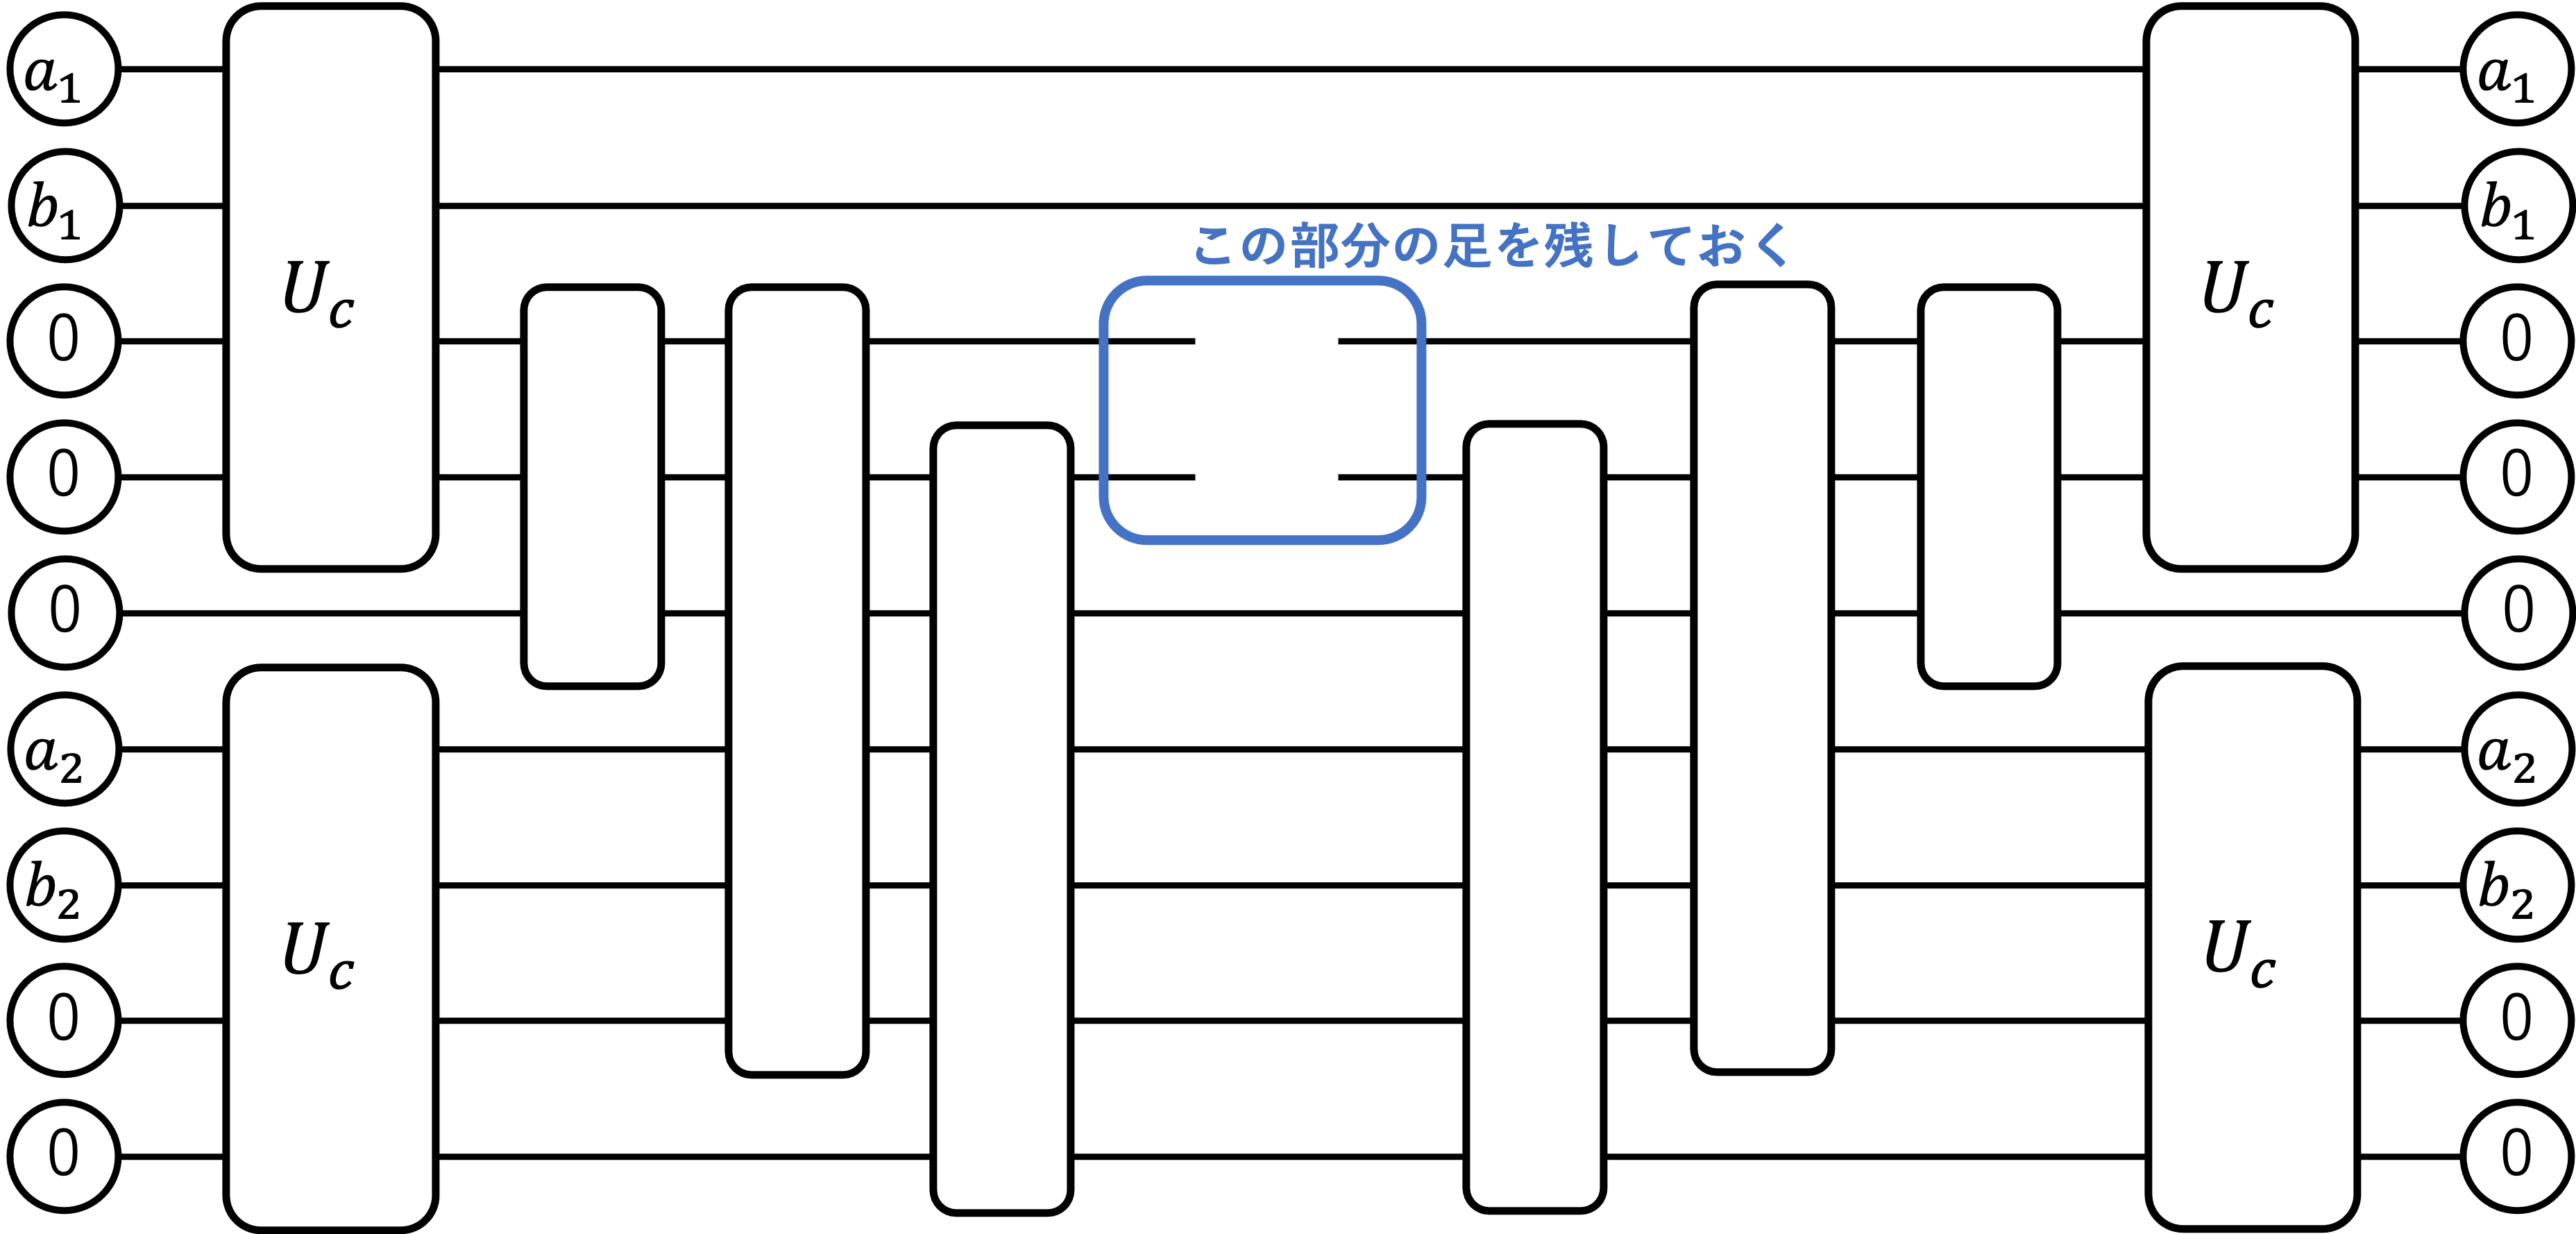

（簡単のため、記載を省略しており、図中ではTofforiゲートが多くの足を持っているように見えるが、接続しているのは3量子ビットのみ）

以下では、このようなテンソルネットワークを組み立てていく

In [ ]:
import tensornetwork as tn

本来の量子コンピュータでは、トフォリゲートは複数の2量子ビット以下のゲートに分解する必要があるが、今回のシミュレーションでは、$2^3 \times 2^3$の大きな行列として、そのまま扱うこととする

In [ ]:
# パラメータ設定
bit_length = 3
n_qubits = bit_length * 5 - 1

In [ ]:
# 各種ゲートの定義
h_gate = np.array([[1, 1], [1, -1]]) / np.sqrt(2)

x_gate = np.array([[0, 1], [1, 0]])

cx_gate = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])

toffori_gate = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
                         [0, 1, 0, 0, 0, 0, 0, 0],
                         [0, 0, 1, 0, 0, 0, 0, 0],
                         [0, 0, 0, 1, 0, 0, 0, 0],
                         [0, 0, 0, 0, 1, 0, 0, 0],
                         [0, 0, 0, 0, 0, 1, 0, 0],
                         [0, 0, 0, 0, 0, 0, 0, 1],
                         [0, 0, 0, 0, 0, 0, 1, 0]])

### ノードの定義

双方向のネットワークを作成するため、まずは順方向から作成していく。

#### 順方向

In [ ]:
initial_nodes = []

# ここでは直接、ノードに入力する初期状態を変えている
# 後の演習では、ここを変更してもらう
for i in range(n_qubits):
    if i == 0:
        initial_nodes.append(tn.Node(np.array([0, 1]))) 
    else:
        initial_nodes.append(tn.Node(np.array([1, 0])))

In [ ]:
# 以下は変更不要
first_layer_gate_nodes = []

for i in range(bit_length):
    first_layer_gate_nodes.append(tn.Node(x_gate)) # 2nd bit, before toffori

    first_layer_gate_nodes.append(tn.Node(toffori_gate.reshape(2,2,2,2,2,2))) # c(1, 2)  t(3)

    first_layer_gate_nodes.append(tn.Node(x_gate)) # 1st bit, before toffori
    first_layer_gate_nodes.append(tn.Node(x_gate)) # 2nd bit, after toffori

    first_layer_gate_nodes.append(tn.Node(toffori_gate.reshape(2,2,2,2,2,2))) # c(1, 2)  t(4)

    first_layer_gate_nodes.append(tn.Node(x_gate)) # 1st bit, after toffori

In [ ]:
second_layer_gate_nodes = []

for i in range(bit_length - 1):
    second_layer_gate_nodes.append(tn.Node(x_gate)) # 1st bit before toffori
    second_layer_gate_nodes.append(tn.Node(x_gate)) # 2nd bit before toffori
    second_layer_gate_nodes.append(tn.Node(toffori_gate.reshape(2,2,2,2,2,2)))
    second_layer_gate_nodes.append(tn.Node(x_gate)) # 1st bit after toffori
    second_layer_gate_nodes.append(tn.Node(x_gate)) # 2nd bit after toffori

In [ ]:
third_layer_gate_nodes = []

for i in range(bit_length - 1):
    third_layer_gate_nodes.append(tn.Node(toffori_gate.reshape(2,2,2,2,2,2)))
    third_layer_gate_nodes.append(tn.Node(toffori_gate.reshape(2,2,2,2,2,2)))

#### 逆方向

同じ内容のネットワークをもう一つ作成する

初期状態を変えて実験する場合、初期状態を順方向と合わせるのを忘れずに

In [ ]:
initial_nodes_r = []

# 後の演習では、ここを変更してもらう
for i in range(n_qubits):
    if i == 0:
        initial_nodes_r.append(tn.Node(np.array([0, 1])))
    else:
        initial_nodes_r.append(tn.Node(np.array([1, 0])))

In [ ]:
# 以下は変更不要
first_layer_gate_nodes_r = []

for i in range(bit_length):
    first_layer_gate_nodes_r.append(tn.Node(x_gate)) # 2nd bit, before toffori

    first_layer_gate_nodes_r.append(tn.Node(toffori_gate.reshape(2,2,2,2,2,2))) # c(1, 2)  t(3)

    first_layer_gate_nodes_r.append(tn.Node(x_gate)) # 1st bit, before toffori
    first_layer_gate_nodes_r.append(tn.Node(x_gate)) # 2nd bit, after toffori

    first_layer_gate_nodes_r.append(tn.Node(toffori_gate.reshape(2,2,2,2,2,2))) # c(1, 2)  t(4)

    first_layer_gate_nodes_r.append(tn.Node(x_gate)) # 1st bit, after toffori

In [ ]:
second_layer_gate_nodes_r = []

for i in range(bit_length - 1):
    second_layer_gate_nodes_r.append(tn.Node(x_gate)) # 1st bit before toffori
    second_layer_gate_nodes_r.append(tn.Node(x_gate)) # 2nd bit before toffori
    second_layer_gate_nodes_r.append(tn.Node(toffori_gate.reshape(2,2,2,2,2,2)))
    second_layer_gate_nodes_r.append(tn.Node(x_gate)) # 1st bit after toffori
    second_layer_gate_nodes_r.append(tn.Node(x_gate)) # 2nd bit after toffori

In [ ]:
third_layer_gate_nodes_r = []

for i in range(bit_length - 1):
    third_layer_gate_nodes_r.append(tn.Node(toffori_gate.reshape(2,2,2,2,2,2)))
    third_layer_gate_nodes_r.append(tn.Node(toffori_gate.reshape(2,2,2,2,2,2)))

## エッジの定義

In [ ]:
# initial_nodes -> first_layer_nodes

for i in range(bit_length):
    tn.connect(initial_nodes[i*5][0], first_layer_gate_nodes[i*6 + 1][0])
    tn.connect(initial_nodes[i*5 + 1][0], first_layer_gate_nodes[i*6][0])
    tn.connect(initial_nodes[i*5 + 2][0], first_layer_gate_nodes[i*6 + 1][2])
    tn.connect(initial_nodes[i*5 + 3][0], first_layer_gate_nodes[i*6 + 4][2])

    if i != bit_length - 1:
        tn.connect(initial_nodes[i*5 + 4][0], second_layer_gate_nodes[i*5 + 2][2])

In [ ]:
# in first_layer_nodes

for i in range(bit_length):
    tn.connect(first_layer_gate_nodes[i*6 + 0][1], first_layer_gate_nodes[i*6 + 1][1])
    tn.connect(first_layer_gate_nodes[i*6 + 1][3], first_layer_gate_nodes[i*6 + 2][0])
    tn.connect(first_layer_gate_nodes[i*6 + 1][4], first_layer_gate_nodes[i*6 + 3][0])

    tn.connect(first_layer_gate_nodes[i*6 + 2][1], first_layer_gate_nodes[i*6 + 4][0])
    tn.connect(first_layer_gate_nodes[i*6 + 3][1], first_layer_gate_nodes[i*6 + 4][1])

    tn.connect(first_layer_gate_nodes[i*6 + 4][3], first_layer_gate_nodes[i*6 + 5][0])

In [ ]:
# first_layer_nodes -> second_layer_nodes

for i in range(bit_length - 1):
    tn.connect(first_layer_gate_nodes[i*6 + 1][5], second_layer_gate_nodes[i*5 + 0][0])
    tn.connect(first_layer_gate_nodes[i*6 + 4][5], second_layer_gate_nodes[i*5 + 1][0])

In [ ]:
# in second_layer_nodes

for i in range(bit_length - 1):
    tn.connect(second_layer_gate_nodes[i*5 + 0][1], second_layer_gate_nodes[i*5 + 2][0])
    tn.connect(second_layer_gate_nodes[i*5 + 1][1], second_layer_gate_nodes[i*5 + 2][1])

    tn.connect(second_layer_gate_nodes[i*5 + 2][3], second_layer_gate_nodes[i*5 + 3][0])
    tn.connect(second_layer_gate_nodes[i*5 + 2][4], second_layer_gate_nodes[i*5 + 4][0])

In [ ]:
# second_layer_nodes -> third_layer_nodes

for i in range(bit_length - 1):
    tn.connect(second_layer_gate_nodes[i*5 + 2][5], third_layer_gate_nodes[i*2 + 0][1])
    tn.connect(second_layer_gate_nodes[i*5 + 3][1], third_layer_gate_nodes[i*2 + 0][2])
    tn.connect(second_layer_gate_nodes[i*5 + 4][1], third_layer_gate_nodes[i*2 + 1][2])

In [ ]:
# first_layer_nodes -> third_layer_nodes
tn.connect(first_layer_gate_nodes[-2][5], third_layer_gate_nodes[-1][0])
tn.connect(first_layer_gate_nodes[-5][5], third_layer_gate_nodes[-2][0]);

In [ ]:
# in third_layer_nodes
for i in range(bit_length - 1):
    tn.connect(third_layer_gate_nodes[i*2 + 0][4], third_layer_gate_nodes[i*2 + 1][1])

    if i != 0:
        tn.connect(third_layer_gate_nodes[i*2 + 0][5], third_layer_gate_nodes[i*2 - 2][0])
        tn.connect(third_layer_gate_nodes[i*2 + 1][5], third_layer_gate_nodes[i*2 - 1][0])

#### 逆方向

In [ ]:
# initial_nodes_r -> first_layer_nodes_r

for i in range(bit_length):
    tn.connect(initial_nodes_r[i*5][0], first_layer_gate_nodes_r[i*6 + 1][0])
    tn.connect(initial_nodes_r[i*5 + 1][0], first_layer_gate_nodes_r[i*6][0])
    tn.connect(initial_nodes_r[i*5 + 2][0], first_layer_gate_nodes_r[i*6 + 1][2])
    tn.connect(initial_nodes_r[i*5 + 3][0], first_layer_gate_nodes_r[i*6 + 4][2])

    if i != bit_length - 1:
        tn.connect(initial_nodes_r[i*5 + 4][0], second_layer_gate_nodes_r[i*5 + 2][2])

In [ ]:
for i in range(bit_length):
    tn.connect(first_layer_gate_nodes_r[i*6 + 0][1], first_layer_gate_nodes_r[i*6 + 1][1])
    tn.connect(first_layer_gate_nodes_r[i*6 + 1][3], first_layer_gate_nodes_r[i*6 + 2][0])
    tn.connect(first_layer_gate_nodes_r[i*6 + 1][4], first_layer_gate_nodes_r[i*6 + 3][0])

    tn.connect(first_layer_gate_nodes_r[i*6 + 2][1], first_layer_gate_nodes_r[i*6 + 4][0])
    tn.connect(first_layer_gate_nodes_r[i*6 + 3][1], first_layer_gate_nodes_r[i*6 + 4][1])

    tn.connect(first_layer_gate_nodes_r[i*6 + 4][3], first_layer_gate_nodes_r[i*6 + 5][0])

In [ ]:
# first_layer_nodes_r -> second_layer_nodes_r

for i in range(bit_length - 1):
    tn.connect(first_layer_gate_nodes_r[i*6 + 1][5], second_layer_gate_nodes_r[i*5 + 0][0])
    tn.connect(first_layer_gate_nodes_r[i*6 + 4][5], second_layer_gate_nodes_r[i*5 + 1][0])

In [ ]:
# in second_layer_nodes_r

for i in range(bit_length - 1):
    tn.connect(second_layer_gate_nodes_r[i*5 + 0][1], second_layer_gate_nodes_r[i*5 + 2][0])
    tn.connect(second_layer_gate_nodes_r[i*5 + 1][1], second_layer_gate_nodes_r[i*5 + 2][1])

    tn.connect(second_layer_gate_nodes_r[i*5 + 2][3], second_layer_gate_nodes_r[i*5 + 3][0])
    tn.connect(second_layer_gate_nodes_r[i*5 + 2][4], second_layer_gate_nodes_r[i*5 + 4][0])

In [ ]:
# second_layer_nodes_r -> third_layer_nodes_r

for i in range(bit_length - 1):
    tn.connect(second_layer_gate_nodes_r[i*5 + 2][5], third_layer_gate_nodes_r[i*2 + 0][1])
    tn.connect(second_layer_gate_nodes_r[i*5 + 3][1], third_layer_gate_nodes_r[i*2 + 0][2])
    tn.connect(second_layer_gate_nodes_r[i*5 + 4][1], third_layer_gate_nodes_r[i*2 + 1][2])

In [ ]:
# first_layer_nodes_r -> third_layer_nodes_r
tn.connect(first_layer_gate_nodes_r[-2][5], third_layer_gate_nodes_r[-1][0])
tn.connect(first_layer_gate_nodes_r[-5][5], third_layer_gate_nodes_r[-2][0]);

In [ ]:
# in third_layer_nodes_r
for i in range(bit_length - 1):
    tn.connect(third_layer_gate_nodes_r[i*2 + 0][4], third_layer_gate_nodes_r[i*2 + 1][1])

    if i != 0:
        tn.connect(third_layer_gate_nodes_r[i*2 + 0][5], third_layer_gate_nodes_r[i*2 - 2][0])
        tn.connect(third_layer_gate_nodes_r[i*2 + 1][5], third_layer_gate_nodes_r[i*2 - 1][0])

#### 順方向と逆方向の結合

最後に、二つのネットワークを結合させる。この際、測定に対応する部分は結合しないようにする。

In [ ]:
for i in range(bit_length):
    tn.connect(first_layer_gate_nodes[i*6 + 5][1], first_layer_gate_nodes_r[i*6 + 5][1])
    tn.connect(first_layer_gate_nodes[i*6 + 4][4], first_layer_gate_nodes_r[i*6 + 4][4])


for i in range(bit_length - 1):
    tn.connect(third_layer_gate_nodes[i*2 + 0][3], third_layer_gate_nodes_r[i*2 + 0][3])
    tn.connect(third_layer_gate_nodes[i*2 + 1][3], third_layer_gate_nodes_r[i*2 + 1][3])
    tn.connect(third_layer_gate_nodes[i*2 + 1][4], third_layer_gate_nodes_r[i*2 + 1][4])

## 縮約計算

測定をしたい足の部分だけをそのまま外に出し、縮約を取ります

In [ ]:
%%time
nodes = (initial_nodes + first_layer_gate_nodes + second_layer_gate_nodes + third_layer_gate_nodes + 
         initial_nodes_r + first_layer_gate_nodes_r + second_layer_gate_nodes_r + third_layer_gate_nodes_r)

output_edges = []

output_edges.append(third_layer_gate_nodes[0][5])
output_edges.append(third_layer_gate_nodes[1][5])

output_edges.append(third_layer_gate_nodes_r[0][5])
output_edges.append(third_layer_gate_nodes_r[1][5])

result = tn.contractors.auto(nodes=nodes, output_edge_order=output_edges)

得られた密度行列の対角成分を確認することで、確率が得られます  
（左上から、00, 01, 10, 11に対応）

In [ ]:
result.tensor.reshape(4,4)

## 課題2

入力する状態や、ビット長を自由に変えて挙動を確認してみましょう。

Qiskitではメモリエラーを起こすようなビット長でも、テンソルネットワークシミュレーションでは高速に解けます。